In [356]:
CREATE_EEGS = False
TRAIN_MODEL = False

In [357]:
import pandas as pd, numpy as np, os
import matplotlib.pyplot as plt

train = pd.read_csv('/home/teerawat.c/projects/HMS_HBAC/datasets/hms-harmful-brain-activity-classification/train.csv')
train.shape, train.head()

((106800, 15),
        eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
 0  1628180742           0                       0.0          353733   
 1  1628180742           1                       6.0          353733   
 2  1628180742           2                       8.0          353733   
 3  1628180742           3                      18.0          353733   
 4  1628180742           4                      24.0          353733   
 
    spectrogram_sub_id  spectrogram_label_offset_seconds    label_id  \
 0                   0                               0.0   127492639   
 1                   1                               6.0  3887563113   
 2                   2                               8.0  1142670488   
 3                   3                              18.0  2718991173   
 4                   4                              24.0  3080632009   
 
    patient_id expert_consensus  seizure_vote  lpd_vote  gpd_vote  lrda_vote  \
 0       42516          Seizure      

In [358]:
df = pd.read_parquet('/home/teerawat.c/projects/HMS_HBAC/datasets/hms-harmful-brain-activity-classification/train_eegs/1000913311.parquet')
FEATS = df.columns
print(f'There are {len(FEATS)} raw eeg features: {list(FEATS)}')

There are 20 raw eeg features: ['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']


In [359]:
FEATS = ['Fp1','T3','C3','O1','Fp2','C4','T4','O2']
FEAT2IDX = {x:y for x,y in zip(FEATS, range(len(FEATS)))}
print(f'We will use the following subset of raw EEG features: {FEATS}')

We will use the following subset of raw EEG features: ['Fp1', 'T3', 'C3', 'O1', 'Fp2', 'C4', 'T4', 'O2']


In [360]:
len(train.eeg_id.unique()), train.eeg_id.unique()

(17089,
 array([1628180742, 2277392603,  722738444, ..., 1850739625, 1306668185,
         351917269]))

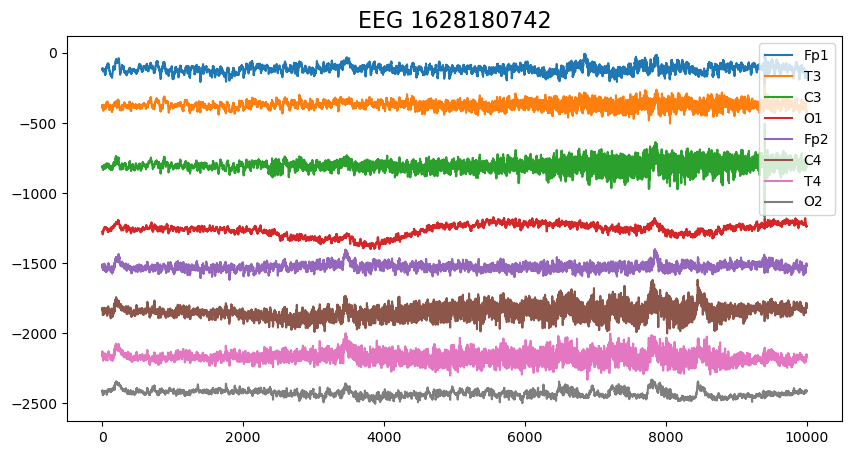

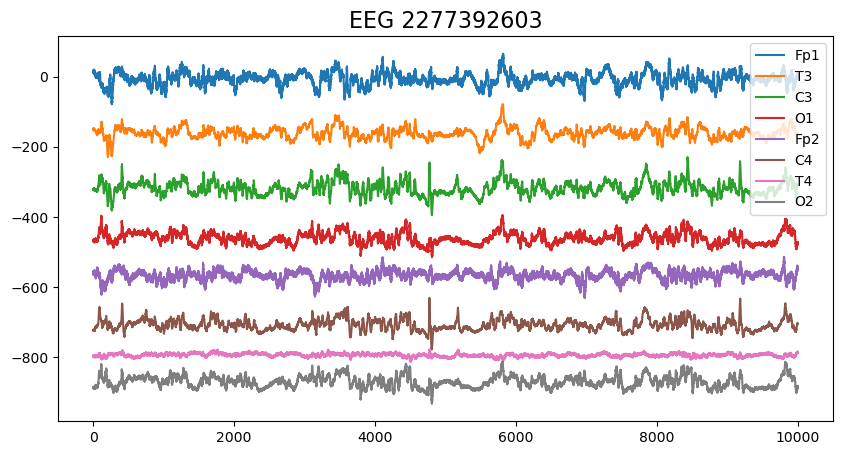

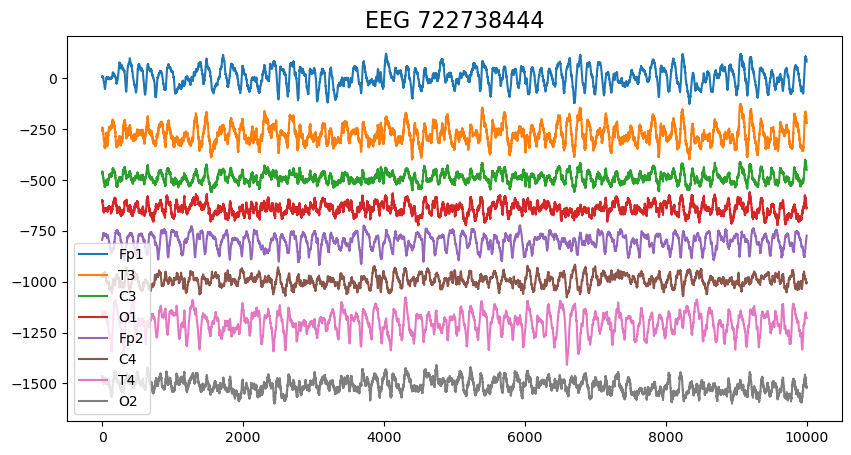

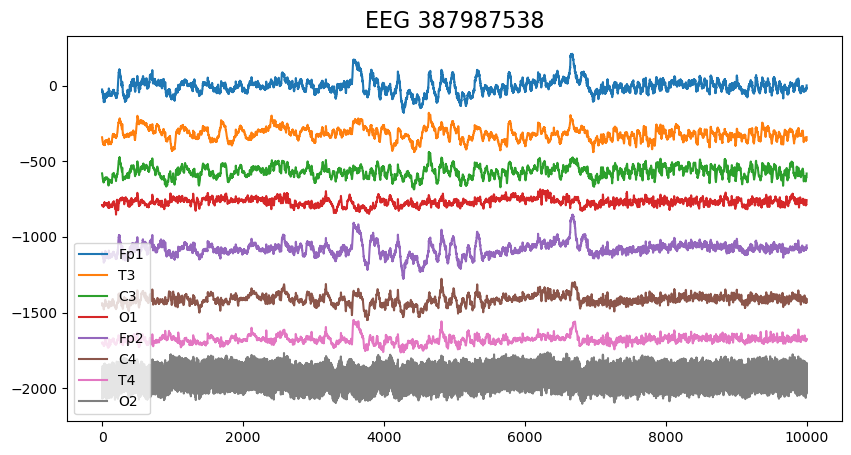

Reading 17089 eeg NumPys from disk.
CPU times: user 7.77 s, sys: 9.3 s, total: 17.1 s
Wall time: 16.7 s


In [361]:
%%time

all_eegs = {}
DISPLAY = 4
EEG_IDS = train.eeg_id.unique()
PATH = '/home/teerawat.c/projects/HMS_HBAC/datasets/hms-harmful-brain-activity-classification/train_eegs/'

for i,eeg_id in enumerate(EEG_IDS):
    if (i%100==0)&(i!=0): print(i,', ',end='') 
    
    # SAVE EEG TO PYTHON DICTIONARY OF NUMPY ARRAYS
    data = eeg_from_parquet(f'{PATH}{eeg_id}.parquet', display=i<DISPLAY)              
    all_eegs[eeg_id] = data
    
    if i==DISPLAY:
        if CREATE_EEGS:
            print(f'Processing {train.eeg_id.nunique()} eeg parquets... ',end='')
        else:
            print(f'Reading {len(EEG_IDS)} eeg NumPys from disk.')
            break
            
if CREATE_EEGS: 
    np.save('eegs',all_eegs)
else:
    all_eegs = np.load('/home/teerawat.c/projects/HMS_HBAC/datasets/brain-eegs/eegs.npy',allow_pickle=True).item()

In [362]:
# Deduplicate Train EEG Id

df = pd.read_csv('/home/teerawat.c/projects/HMS_HBAC/datasets/hms-harmful-brain-activity-classification/train.csv')
TARGETS = df.columns[-6:]
TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}
TARS2 = {x:y for y,x in TARS.items()}

train = df.groupby('eeg_id')[['patient_id']].agg('first')

tmp = df.groupby('eeg_id')[TARGETS].agg('sum')
for t in TARGETS:
    train[t] = tmp[t].values
    
y_data = train[TARGETS].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train[TARGETS] = y_data

tmp = df.groupby('eeg_id')[['expert_consensus']].agg('first')
train['target'] = tmp

train = train.reset_index()
train = train.loc[train.eeg_id.isin(EEG_IDS)]
print('Train Data with unique eeg_id shape:', train.shape )
train.head()

Train Data with unique eeg_id shape: (17089, 9)


,eeg_id,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other
1,582999,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD
2,642382,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
3,751790,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD
4,778705,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other


In [363]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd

In [364]:
from scipy.signal import butter, lfilter

def butter_lowpass_filter(data, cutoff_freq=20, sampling_rate=200, order=4):
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = lfilter(b, a, data, axis=0)
    return filtered_data

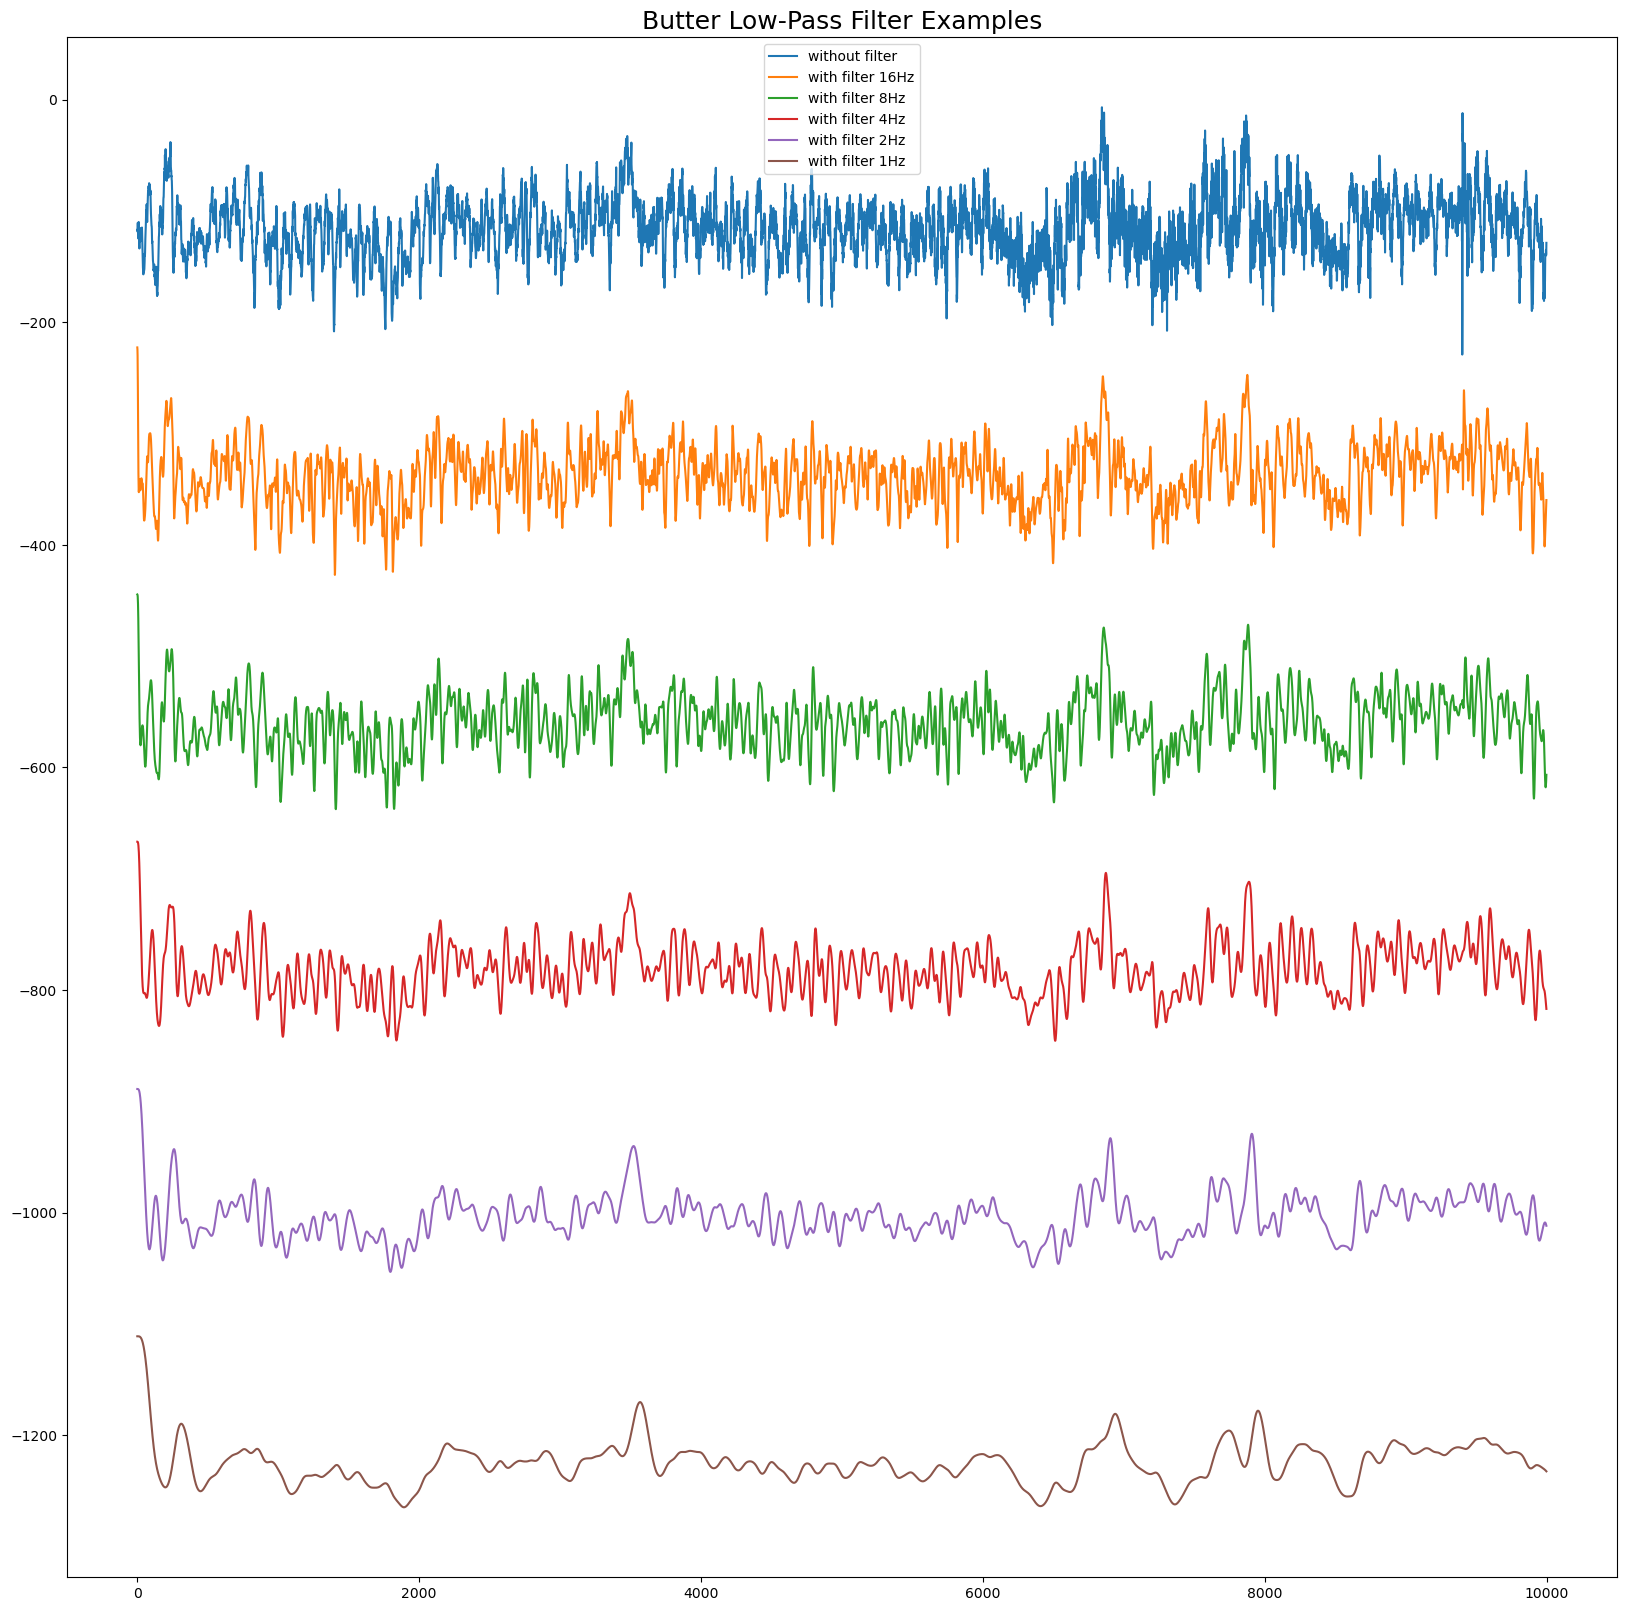

In [365]:
FREQS = [1,2,4,8,16][::-1]
x = [all_eegs[EEG_IDS[0]][:,0]]
for k in FREQS:
    x.append( butter_lowpass_filter(x[0], cutoff_freq=k) )

plt.figure(figsize=(20,20))
plt.plot(range(10_000),x[0], label='without filter')
for k in range(1,len(x)):
    plt.plot(range(10_000),x[k]-k*(x[0].max()-x[0].min()), label=f'with filter {FREQS[k-1]}Hz')
plt.legend()
plt.title('Butter Low-Pass Filter Examples',size=18)
plt.show()

In [411]:
from typing import Dict, List

In [412]:
class CustomDataset(Dataset):
    def __init__(
        self, df: pd.DataFrame, batch_size, mode: str = 'train',
        eegs: Dict[int, np.ndarray] = all_eegs, downsample: int = 5
    ): 
        self.df = df
        self.batch_size = batch_size
        self.mode = mode
        self.eegs = eegs
        self.downsample = downsample
        
    def __len__(self):
        """
        Length of dataset.
        """
        return len(self.df)
        
    def __getitem__(self, index):
        """
        Get one item.
        """
        X, y = self.__data_generation(index)
        X = X[::self.downsample,:]
        output = {
            "X": torch.tensor(X, dtype=torch.float32),
            "y": torch.tensor(y, dtype=torch.float32)
        }
        return output
                        
    def __data_generation(self, index):
        'Generates one sample of data'
        row = self.df.iloc[index]
        X = np.zeros((10_000, 8), dtype='float32')
        y = np.zeros(6, dtype='float32')
        data = self.eegs[row.eeg_id]

        # === Feature engineering ===
        X[:,0] = data[:,FEAT2IDX['Fp1']] - data[:,FEAT2IDX['T3']]
        X[:,1] = data[:,FEAT2IDX['T3']] - data[:,FEAT2IDX['O1']]

        X[:,2] = data[:,FEAT2IDX['Fp1']] - data[:,FEAT2IDX['C3']]
        X[:,3] = data[:,FEAT2IDX['C3']] - data[:,FEAT2IDX['O1']]

        X[:,4] = data[:,FEAT2IDX['Fp2']] - data[:,FEAT2IDX['C4']]
        X[:,5] = data[:,FEAT2IDX['C4']] - data[:,FEAT2IDX['O2']]

        X[:,6] = data[:,FEAT2IDX['Fp2']] - data[:,FEAT2IDX['T4']]
        X[:,7] = data[:,FEAT2IDX['T4']] - data[:,FEAT2IDX['O2']]

        # === Standarize ===
        X = np.clip(X,-1024, 1024)
        X = np.nan_to_num(X, nan=0) / 32.0

        # === Butter Low-pass Filter ===
        X = butter_lowpass_filter(X)
        
        if self.mode != 'test':
            y = row[TARGETS].values.astype(np.float32)
            
        return X, y

In [413]:
train_dataset = CustomDataset(train, 32, mode="train")
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=False,
    pin_memory=True, drop_last=True
)
output = train_dataset[0]
X, y = output["X"], output["y"]
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: torch.Size([2000, 8])
y shape: torch.Size([6])


In [366]:
class EEGDataset(Dataset):
    'EEG Dataset for PyTorch'
    def __init__(self, data, eegs, mode='train', downsample=5):
        self.data = data
        self.eegs = eegs
        self.mode = mode
        self.downsample = downsample
        
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.data)

    def __getitem__(self, index):
        'Generates one sample of data'
        row = self.data.iloc[index]
        data = self.eegs[row.eeg_id]
        
        # Adapted feature engineering process
        X = self.feature_engineering(data)
        
        if self.mode != 'test':
            y = row[TARGETS].values.astype('float32')  # Ensure TARGETS is defined as your label columns
            return X, torch.from_numpy(y)
        else:
            return X

    def feature_engineering(self, data):
        sample = np.zeros((10000, 8), dtype='float32')  # Assuming data shape and desired sample shape
        
        # Implementing the feature engineering as specified
        sample[:,0] = data[:,FEAT2IDX['Fp1']] - data[:,FEAT2IDX['T3']]
        sample[:,1] = data[:,FEAT2IDX['T3']] - data[:,FEAT2IDX['O1']]
        sample[:,2] = data[:,FEAT2IDX['Fp1']] - data[:,FEAT2IDX['C3']]
        sample[:,3] = data[:,FEAT2IDX['C3']] - data[:,FEAT2IDX['O1']]
        sample[:,4] = data[:,FEAT2IDX['Fp2']] - data[:,FEAT2IDX['C4']]
        sample[:,5] = data[:,FEAT2IDX['C4']] - data[:,FEAT2IDX['O2']]
        sample[:,6] = data[:,FEAT2IDX['Fp2']] - data[:,FEAT2IDX['T4']]
        sample[:,7] = data[:,FEAT2IDX['T4']] - data[:,FEAT2IDX['O2']]

        # Applying further preprocessing steps (e.g., clipping, normalization, and filtering) as in the original class
        sample = np.clip(sample, -1024, 1024)
        sample = np.nan_to_num(sample, nan=0) / 32.0
        sample = butter_lowpass_filter(sample)
        
        # Downsample and convert to tensor
        sample = sample[::self.downsample, :]
        return torch.from_numpy(sample).float()

In [414]:
# Example of initializing dataset and dataloader with your parameters
eeg_dataset = EEGDataset(data=train, eegs=all_eegs, mode='train')
eeg_dataloader = DataLoader(eeg_dataset, batch_size=32, shuffle=False)

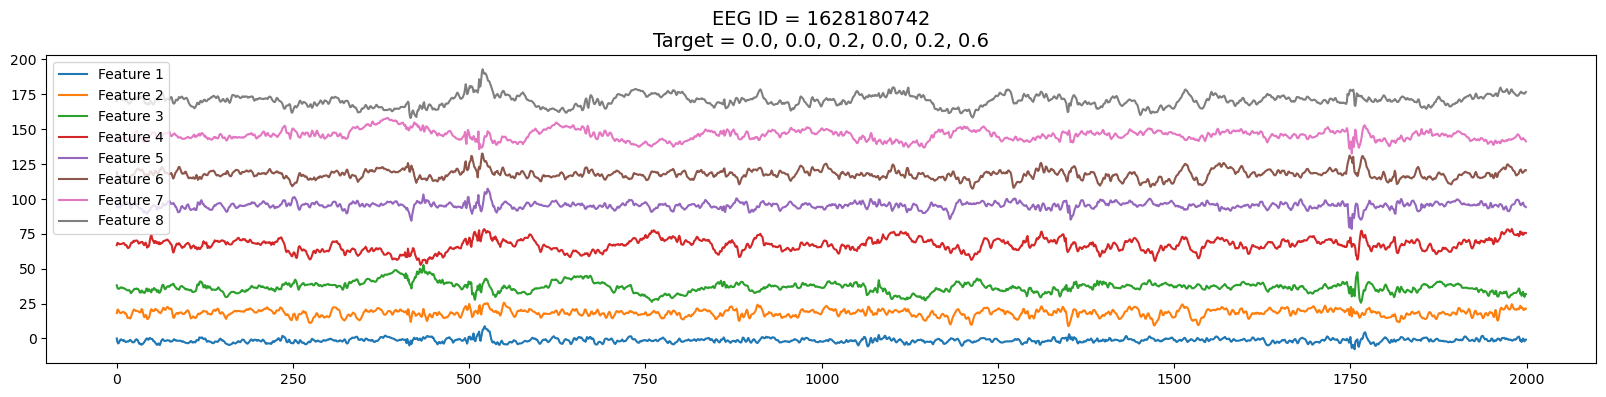

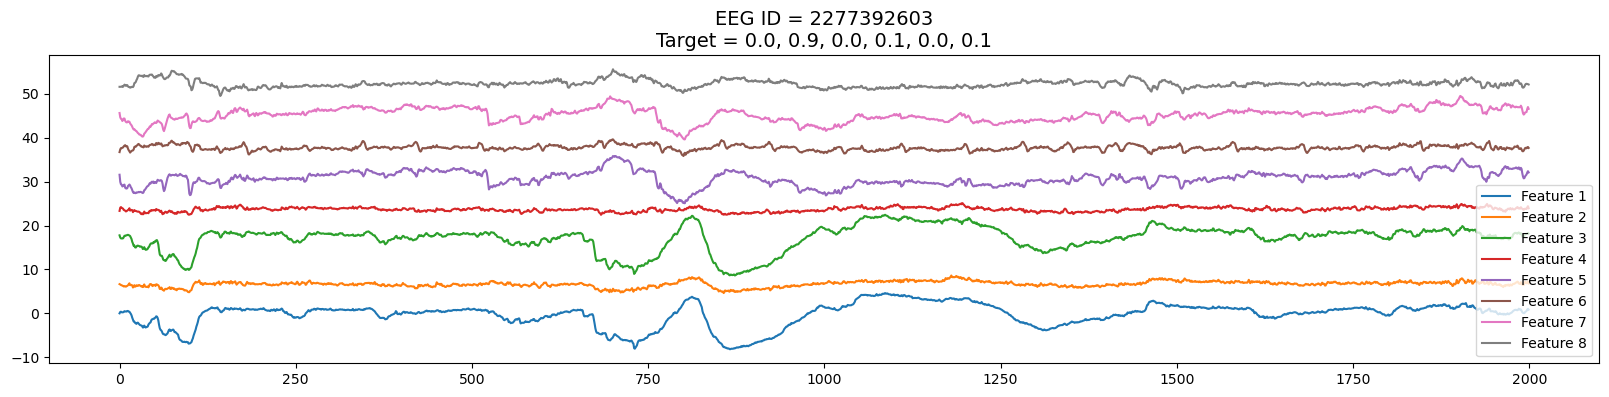

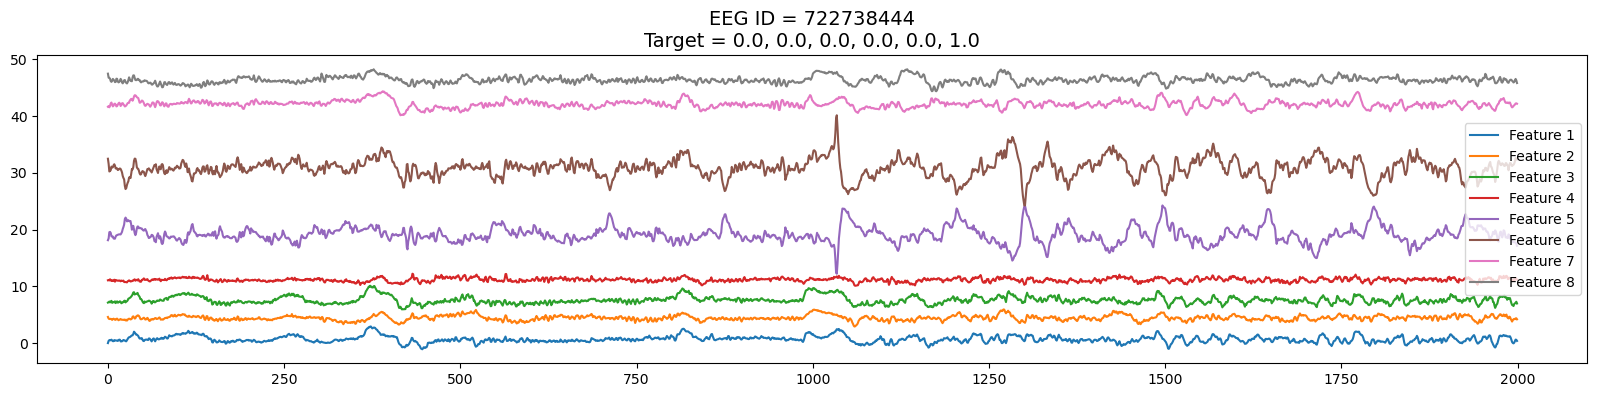

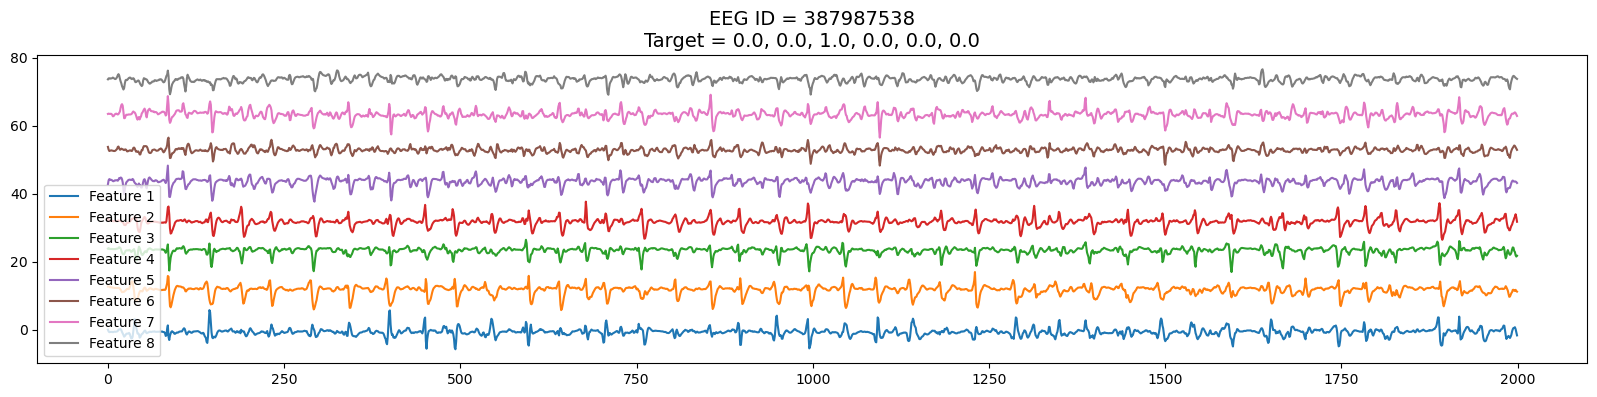

In [415]:
for batch_idx, (x, y) in enumerate(eeg_dataloader):
    # x: features, y: targets
    # Convert x and y back to numpy for visualization if they're tensors
    x = x.numpy()  # Convert tensors to numpy arrays for plotting
    y = y.numpy()

    for k in range(4):
        plt.figure(figsize=(20, 4))
        offset = 0
        for j in range(x.shape[-1]):  # Iterate over the last dimension for features
            if j != 0: offset -= x[k, :, j].min()
            plt.plot(range(x.shape[1]), x[k, :, j] + offset, label=f'Feature {j + 1}')  # Adjust range to match downsampled size
            offset += x[k, :, j].max()

        tt = f'{y[k][0]:0.1f}'
        for t in y[k][1:]:
            tt += f', {t:0.1f}'

        # Assuming you have a way to access or generate EEG_IDS for plotting
        plt.title(f'EEG ID = {EEG_IDS[k] if len(EEG_IDS) > k else "Unknown"}\nTarget = {tt}', size=14)
        plt.legend()
        plt.show()

    if batch_idx == 0:  # Only process the first batch
        break

In [416]:
len(eeg_dataset), eeg_dataset.__getitem__(0)

(17089,
 (tensor([[-0.0186,  0.0168, -0.0133,  ..., -0.0195, -0.0248,  0.0136],
          [-2.7153,  2.4285, -1.9531,  ..., -3.0226, -3.8808,  2.0654],
          [-3.5945,  2.5021, -2.5035,  ..., -4.2928, -5.5799,  2.2484],
          ...,
          [-2.1004,  2.7206, -8.2896,  ...,  0.6811, -3.9549,  5.3968],
          [-0.8810,  3.3787, -6.3798,  ...,  1.3858, -4.2617,  6.1737],
          [-0.8026,  3.2428, -6.2627,  ...,  1.2895, -5.2117,  6.6640]]),
  tensor([0.0000, 0.0000, 0.2500, 0.0000, 0.1667, 0.5833])))

In [369]:
dataset = EEGDataset(data=train, eegs=all_eegs, mode='train')

valid_size = int(0.2 * len(dataset))  # for a 80-20 split
train_size = len(dataset) - valid_size

In [370]:
train_size, valid_size

(13672, 3417)

### model architecture 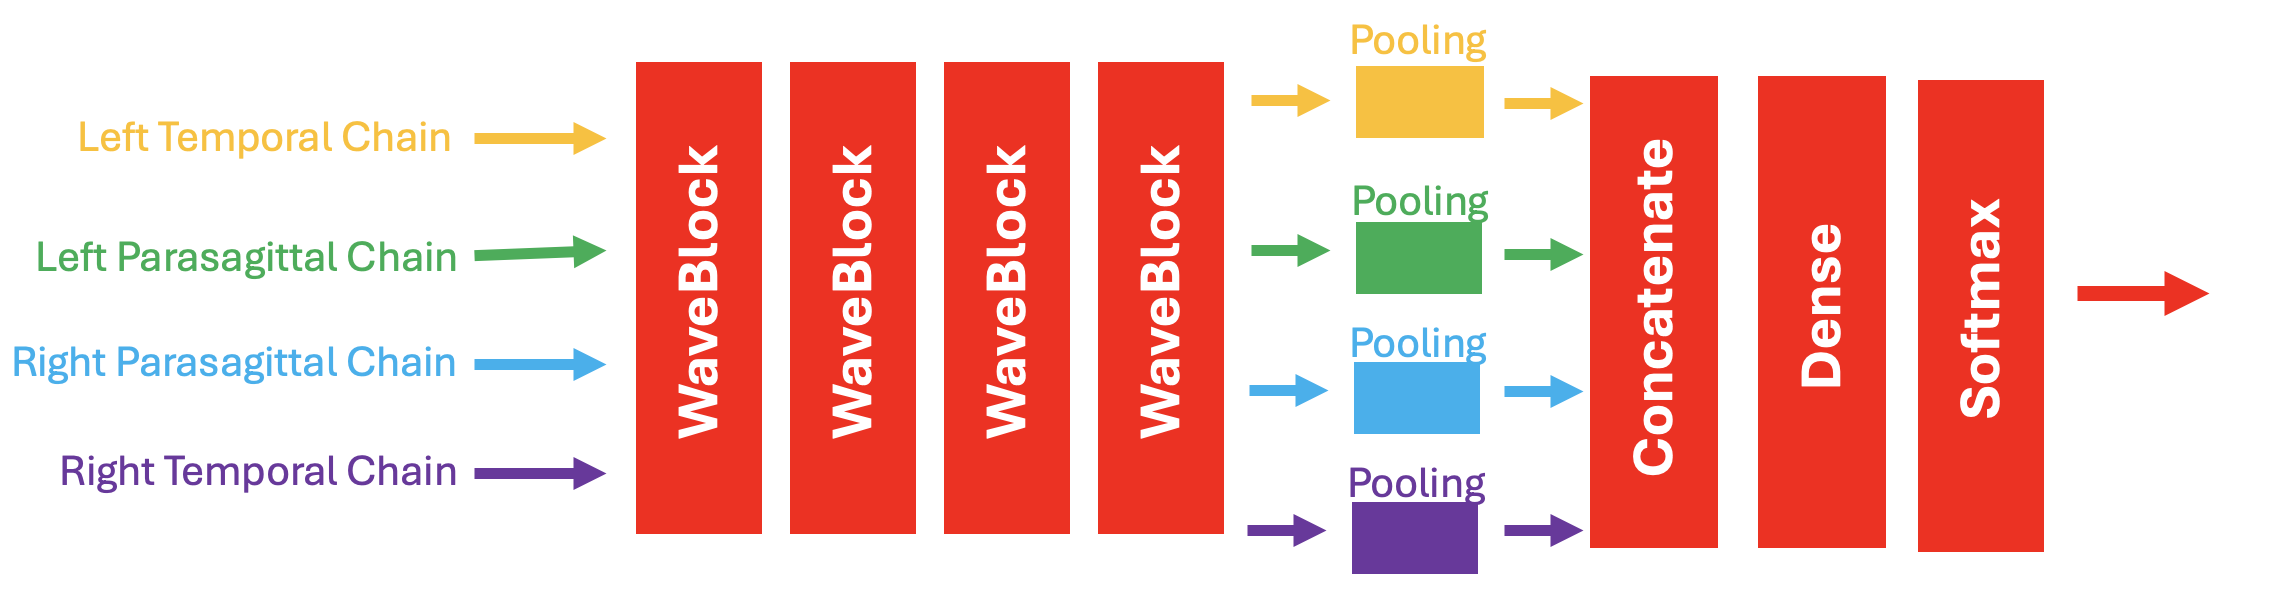

In [371]:
from torch.utils.data import random_split
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

In [372]:
training_loader = DataLoader(train_dataset, shuffle=False, batch_size=32)
validation_loader = DataLoader(valid_dataset, shuffle=False, batch_size=32)

In [451]:
import torch.nn as nn

class Wave_Block(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, dilation_rates: int, kernel_size: int = 3):
        """
        WaveNet building block.
        :param in_channels: number of input channels.
        :param out_channels: number of output channels.
        :param dilation_rates: how many levels of dilations are used.
        :param kernel_size: size of the convolving kernel.
        """
        super(Wave_Block, self).__init__()
        self.num_rates = dilation_rates
        self.convs = nn.ModuleList()
        self.filter_convs = nn.ModuleList()
        self.gate_convs = nn.ModuleList()
        self.convs.append(nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=True))
        
        dilation_rates = [2 ** i for i in range(dilation_rates)]
        for dilation_rate in dilation_rates:
            self.filter_convs.append(
                nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size,
                          padding=int((dilation_rate*(kernel_size-1))/2), dilation=dilation_rate))
            self.gate_convs.append(
                nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size,
                          padding=int((dilation_rate*(kernel_size-1))/2), dilation=dilation_rate))
            self.convs.append(nn.Conv1d(out_channels, out_channels, kernel_size=1, bias=True))
        
        for i in range(len(self.convs)):
            nn.init.xavier_uniform_(self.convs[i].weight, gain=nn.init.calculate_gain('relu'))
            nn.init.zeros_(self.convs[i].bias)

        for i in range(len(self.filter_convs)):
            nn.init.xavier_uniform_(self.filter_convs[i].weight, gain=nn.init.calculate_gain('relu'))
            nn.init.zeros_(self.filter_convs[i].bias)

        for i in range(len(self.gate_convs)):
            nn.init.xavier_uniform_(self.gate_convs[i].weight, gain=nn.init.calculate_gain('relu'))
            nn.init.zeros_(self.gate_convs[i].bias)

    def forward(self, x):
        x = self.convs[0](x)
        res = x
        for i in range(self.num_rates):
            tanh_out = torch.tanh(self.filter_convs[i](x))
            sigmoid_out = torch.sigmoid(self.gate_convs[i](x))
            x = tanh_out * sigmoid_out
            x = self.convs[i + 1](x) 
            res = res + x
        return res
    
class WaveNet(nn.Module):
    def __init__(self, input_channels: int = 1, kernel_size: int = 3):
        super(WaveNet, self).__init__()
        self.model = nn.Sequential(
                Wave_Block(input_channels, 8, 12, kernel_size),
                Wave_Block(8, 16, 8, kernel_size),
                Wave_Block(16, 32, 4, kernel_size),
                Wave_Block(32, 64, 1, kernel_size) 
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.permute(0, 2, 1) 
        output = self.model(x)
        return output


class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.model = WaveNet()
        self.global_avg_pooling = nn.AdaptiveAvgPool1d(1)
        self.dropout = 0.0
        self.head = nn.Sequential(
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.Linear(64, 6)
        )
        
    def forward(self, x: torch.Tensor):
        """
        Forwward pass.
        """
        x1 = self.model(x[:, :, 0:1])
        x1 = self.global_avg_pooling(x1)
        x1 = x1.squeeze()
        x2 = self.model(x[:, :, 1:2])
        x2 = self.global_avg_pooling(x2)
        x2 = x2.squeeze()
        z1 = torch.mean(torch.stack([x1, x2]), dim=0)

        x1 = self.model(x[:, :, 2:3])
        x1 = self.global_avg_pooling(x1)
        x1 = x1.squeeze()
        x2 = self.model(x[:, :, 3:4])
        x2 = self.global_avg_pooling(x2)
        x2 = x2.squeeze()
        z2 = torch.mean(torch.stack([x1, x2]), dim=0)
        
        x1 = self.model(x[:, :, 4:5])
        x1 = self.global_avg_pooling(x1)
        x1 = x1.squeeze()
        x2 = self.model(x[:, :, 5:6])
        x2 = self.global_avg_pooling(x2)
        x2 = x2.squeeze()
        z3 = torch.mean(torch.stack([x1, x2]), dim=0)
        
        x1 = self.model(x[:, :, 6:7])
        x1 = self.global_avg_pooling(x1)
        x1 = x1.squeeze()
        x2 = self.model(x[:, :, 7:8])
        x2 = self.global_avg_pooling(x2)
        x2 = x2.squeeze()
        z4 = torch.mean(torch.stack([x1, x2]), dim=0)
        
        y = torch.cat([z1, z2, z3, z4], dim=1)
        y = self.head(y)
        
        return y

WaveNet_model = CustomModel()
total_params = sum(p.numel() for p in WaveNet_model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 98086


In [452]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
WaveNet_model.to(device)

CustomModel(
  (model): WaveNet(
    (model): Sequential(
      (0): Wave_Block(
        (convs): ModuleList(
          (0): Conv1d(1, 8, kernel_size=(1,), stride=(1,))
          (1-12): 12 x Conv1d(8, 8, kernel_size=(1,), stride=(1,))
        )
        (filter_convs): ModuleList(
          (0): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,))
          (1): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
          (2): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
          (3): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
          (4): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
          (5): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
          (6): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
          (7): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
          (8): Conv

In [453]:
import torchvision.transforms as transforms

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F

In [454]:
from sklearn.metrics import accuracy_score, f1_score
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class ModelTraining:
    def __init__(self, epochs, model, training_loader, validation_loader, learning_rate=0.0008):
        self.epochs = epochs
        self.model = model.to(device)
        self.training_loader = training_loader
        self.validation_loader = validation_loader
        self.best_weights = None
        self.best_vloss = float('inf')

        self.val_losses = []
        self.acc_history = []

        self.optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
        self.loss_fn = torch.nn.KLDivLoss(reduction='batchmean')
        # self.loss_fn = torch.nn.CrossEntropyLoss()

    def train_one_epoch(self, epoch_index, tb_writer):
        self.model.train()  # Set model to training mode
        running_loss = 0.0

        for i, (inputs, labels) in enumerate(self.training_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            self.optimizer.zero_grad()

            outputs = self.model(inputs)
            outputs = F.log_softmax(outputs, dim=1)
            
            loss = self.loss_fn(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(self.training_loader)
        print(f'Epoch {epoch_index + 1}, Training loss: {avg_loss:.4f}')
        tb_writer.add_scalar('Loss/train', avg_loss, epoch_index)

        return avg_loss

    def evaluate(self):
        self.model.eval()  # Set model to evaluation mode
        running_vloss = 0.0
        true_labels = []
        predicted_labels = []

        with torch.no_grad():
            for inputs, labels in self.validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = self.model(inputs)

                outputs = self.model(inputs)
                outputs = F.log_softmax(outputs, dim=1)

                vloss = self.loss_fn(outputs, labels)
                running_vloss += vloss.item()
                
                labels = labels.argmax(dim=1)
                pred_labels = outputs.argmax(dim=1)
                
                true_labels.extend(labels.cpu().numpy())
                predicted_labels.extend(pred_labels.cpu().numpy())

        avg_vloss = running_vloss / len(self.validation_loader)
        accuracy = accuracy_score(true_labels, predicted_labels)
        self.val_losses.append(avg_vloss)
        self.acc_history.append(accuracy)
        print(f'Validation Loss: {avg_vloss:.4f}, Accuracy: {accuracy:.4f}')

        return avg_vloss, accuracy

    def train(self):
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        writer = SummaryWriter(f'runs/eegnet_trainer_{timestamp}')

        for epoch in range(self.epochs):
            print(f'Epoch {epoch + 1}/{self.epochs}')
            avg_loss = self.train_one_epoch(epoch, writer)
            avg_vloss, accuracy = self.evaluate()

            writer.add_scalars('Loss', {'Validation': avg_vloss, 'Accuracy': accuracy}, epoch)

            if avg_vloss < self.best_vloss:
                self.best_vloss = avg_vloss
                self.best_weights = self.model.state_dict()

        writer.close()
        print('Training complete.')

In [455]:
WaveNet_log = ModelTraining(epochs=20, model=WaveNet_model, training_loader=training_loader, validation_loader=validation_loader)
WaveNet_log.train()

Epoch 1/20
Epoch 1, Training loss: 1.0233
Validation Loss: 0.9508, Accuracy: 0.5438
Epoch 2/20
Epoch 2, Training loss: 0.8265
Validation Loss: 0.7782, Accuracy: 0.6365
Epoch 3/20
Epoch 3, Training loss: 0.7213
Validation Loss: 0.6947, Accuracy: 0.6652
Epoch 4/20
Epoch 4, Training loss: 0.6788
Validation Loss: 0.7190, Accuracy: 0.6743
Epoch 5/20
Epoch 5, Training loss: 0.6410
Validation Loss: 0.6805, Accuracy: 0.6831
Epoch 6/20
Epoch 6, Training loss: 0.6173
Validation Loss: 0.6381, Accuracy: 0.6886
Epoch 7/20
Epoch 7, Training loss: 0.6036
Validation Loss: 0.6363, Accuracy: 0.6953
Epoch 8/20
Epoch 8, Training loss: 0.5818
Validation Loss: 0.5803, Accuracy: 0.7117
Epoch 9/20
Epoch 9, Training loss: 0.5715
Validation Loss: 0.6269, Accuracy: 0.6857
Epoch 10/20
Epoch 10, Training loss: 0.5620
Validation Loss: 0.5830, Accuracy: 0.7211
Epoch 11/20
Epoch 11, Training loss: 0.5465
Validation Loss: 0.5768, Accuracy: 0.7152
Epoch 12/20
Epoch 12, Training loss: 0.5406
Validation Loss: 0.6171, Acc

In [456]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
epoch = WaveNet_log.epochs - 1 # number of epochs - 1

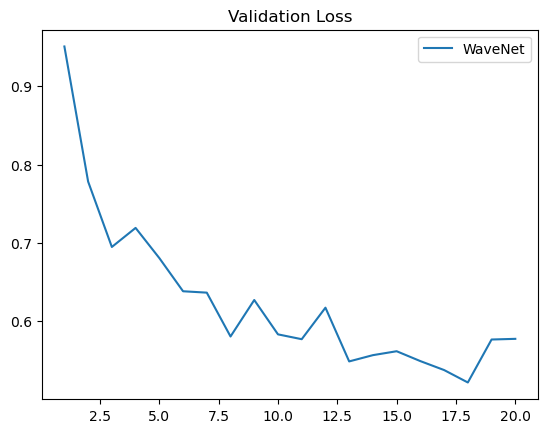

In [457]:
plt.title("Validation Loss")
plt.plot(np.arange(1, epoch+2), np.array(WaveNet_log.val_losses), label='WaveNet')
plt.legend()

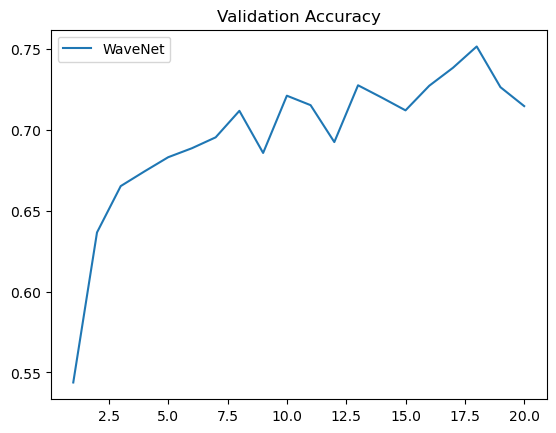

In [458]:
plt.title("Validation Accuracy")
plt.plot(np.arange(1, epoch+2), np.array(WaveNet_log.acc_history), label='WaveNet')
plt.legend()

In [459]:
WaveNet_log.best_weights

OrderedDict([('model.model.0.convs.0.weight',
              tensor([[[ 0.4525]],
              
                      [[ 0.9801]],
              
                      [[-0.9738]],
              
                      [[-0.4792]],
              
                      [[-0.8088]],
              
                      [[ 0.7532]],
              
                      [[-1.0227]],
              
                      [[ 0.4269]]], device='cuda:0')),
             ('model.model.0.convs.0.bias',
              tensor([ 0.0650, -0.0242,  0.0700,  0.0578, -0.0021,  0.0169,  0.0594, -0.0148],
                     device='cuda:0')),
             ('model.model.0.convs.1.weight',
              tensor([[[-0.6806],
                       [-0.4164],
                       [ 0.7258],
                       [ 0.2800],
                       [-0.1177],
                       [ 0.0514],
                       [ 0.8231],
                       [ 0.5708]],
              
                      [[ 0.4178],
  

In [502]:
WaveNet_model.load_state_dict(WaveNet_log.best_weights)
WaveNet_model.eval()
print('Done! Model is loaded...: {}'.format(WaveNet_log.best_vloss))

Done! Model is loaded...: 0.5215094980792464


In [503]:
predicted_labels = []
true_labels = []

for i, (inputs, labels) in enumerate(validation_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    
    outputs = WaveNet_model(inputs).to(device)
    outputs = F.log_softmax(outputs, dim=1)

    # Get predicted labels
    pred_labels = outputs.argmax(dim=1).cpu().numpy()
    labels = labels.argmax(dim=1).cpu().numpy()

    # Update lists
    true_labels.extend(labels)
    predicted_labels.extend(pred_labels)

# Calculate mean accuracy
accuracy_WaveNet = accuracy_score(true_labels, predicted_labels)

In [505]:
print("classification report WaveNet")
print(classification_report(true_labels,predicted_labels,target_names=list(TARGETS)))

classification report WaveNet
              precision    recall  f1-score   support

seizure_vote       0.79      0.60      0.68       576
    lpd_vote       0.87      0.55      0.67       509
    gpd_vote       0.81      0.73      0.77       342
   lrda_vote       0.49      0.25      0.33       170
   grda_vote       0.69      0.57      0.62       362
  other_vote       0.67      0.90      0.77      1458

    accuracy                           0.71      3417
   macro avg       0.72      0.60      0.64      3417
weighted avg       0.73      0.71      0.70      3417



confusion matrix WaveNet


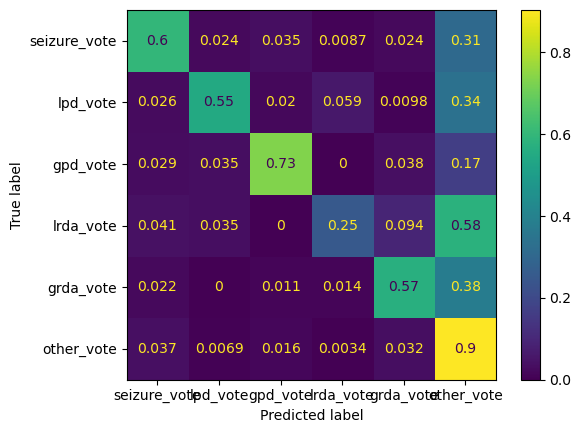

In [504]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("confusion matrix WaveNet")
matrix = confusion_matrix(true_labels, predicted_labels, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=list(TARGETS))
disp.plot()